In [4]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import numpy as np
import os
from matplotlib.lines import Line2D

In [2]:
os.chdir("C://Users//debor//OneDrive//University_Files//Modules//Y2S2//SP3172//data_for_interns//deb_testing")

In [11]:
def umap_reduce(data, labels=None, n_neighbors=15, n_components=2, min_dist=0.0, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist, metric=metric)
    reducer.fit(data, y=labels)
    return reducer.embedding_, reducer

def visualise_reduced(reduced, labels, three_dimensional=False, title=None, save_fig=None, hide=-1):
    fig = plt.figure()
    
    colours = ["tab:blue", "red"]

    ax = fig.add_subplot(projection="3d" if three_dimensional else None)

    if hide == 0 or hide == 1:
        to_plot = reduced[labels != hide]
        to_label = labels[labels != hide]

        if hide == 0:
            colours.remove("tab:blue")
    else:
        to_plot = reduced
        to_label = labels

    cmap = mplc.ListedColormap(colours)
    
    if three_dimensional:
        ax.scatter(to_plot[:, 0], to_plot[:, 1], to_plot[:, 2], c=to_label, s=1, cmap=cmap)
    else:
        ax.scatter(to_plot[:, 0], to_plot[:, 1], c=to_label, s=1, cmap=cmap)

    ax.set_ylabel("UMAP Y")
    ax.set_xlabel("UMAP X")
    # ax.set_zlabel("UMAP Z")

    if title is not None:
        ax.set_title(title)

    legend_ele = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Tremors', markersize=5),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', label='Non-tremors', markersize=5)]

    plt.legend(handles=legend_ele)
    
    if save_fig is not None:
        plt.savefig(save_fig, dpi=300)
    
    plt.show()

def generate_labelled_frames(pose_data_raw, tremour_data_raw, save_as=None, fps=30):
    pose_data = pd.read_csv(pose_data_raw, skiprows=3)
    tremour_data = pd.read_csv(tremour_data_raw)
    labels = []
    for index, row in tremour_data.iterrows():
        start = int(row["temporal_segment_start"]) * fps
        end = int(row["temporal_segment_end"]) * fps
        label = int(row["label"])

        for i in range(start, end):
            labels.append(label)
    
    last_frame = pose_data.shape[0]
    
    remainder = last_frame - len(labels)

    for _ in range(remainder):
        labels.append(0)

    if save_as is not None:
        tremours = pd.DataFrame({"label":labels})
        tremours.to_csv(save_as)

    return labels

In [7]:
def make_bsoid_labels(mapping_path, label_path):
    """
    generate frameshifted labels (compatible with 10 fps like what BSOID does).
    in this case, divides number of labelled frames by 3.
    input: path of tremor labels in FRAMES (after running generate_labelled_frames), path of mapping data from bsoid
    output: squished (10 fps) labels
    """
    labels_raw = pd.read_csv(label_path)["label"]
    squished_labels = []
    
    for i in list(range(len(labels_raw)))[::3]:
        avg = (labels_raw[i:i+3]).mean()
        avg_round = avg.round()
        squished_labels.append(avg_round)
        labels = pd.DataFrame(squished_labels)

    mapping_data = np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, 1]
    mapping_length = len(mapping_data)
    # print(f"mapping length = {mapping_length}")
    final_labels = labels[:mapping_length]
    # print(f"label length = {len(final_labels)}")

    return final_labels

def visualise_bsoid(mapping_path, labels=None, pose_feature=0, n_neighbors=60, n_components=3, title=None, save_fig_path=None):
    """
    plots umap reduction according to bsoid params
    pose_feature refers to the type of feature extraction method (L, D or theta) as shown in bsoid paper
    0 = ENTIRE dataset including last 2 columns of mapping (cluster assignments)
    1 = L, 'pose' in delta pixels, distances between each pair of pose features
    2 = theta, 'pose vector' in delta degrees, angular change between each pair of pose features
    3 = D, 'pose vs. prev time' in delta pixels, displacement of each pose feature across timesteps
    4 = all 3 feature extraction methods
    input: path of mapping data from bsoid, FRAMESHIFT PROCESSED labels (after running make_labels)
    """
    if pose_feature != 0:
        if pose_feature == 1:
            start, stop = 1, 137
        elif pose_feature == 2:
            start, stop = 137, 273
        elif pose_feature == 3:
            start, stop = 273, -2
        elif pose_feature == 4:
            start, stop = 1, -2
        else:
            print("only pose_feature numbers 0 - 4")
            return
        mapping = pd.DataFrame(np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, start:stop])
    else:
        mapping = pd.DataFrame(np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, 1:])
    
    reduced, _ = umap_reduce(mapping, None, n_neighbors=n_neighbors, n_components=n_components)

    visualise_reduced(reduced, labels, title=title, three_dimensional=False, save_fig=save_fig_path)

In [8]:
koi_path = "bsoid_koi_XY//koi_0310_mapping.csv"
koi_tremor_path = "koi_apr11_tremors_frames.csv"
koi_labels = make_bsoid_labels(koi_path, koi_tremor_path)

print(koi_labels)

        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
6307  0.0
6308  0.0
6309  0.0
6310  0.0
6311  0.0

[6312 rows x 1 columns]


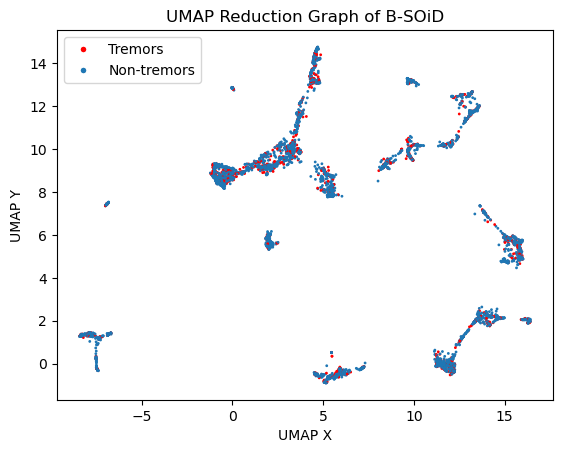

In [10]:
visualise_bsoid(koi_path, koi_labels, n_components=2, pose_feature=4, title="UMAP Reduction Graph of B-SOiD")